# Interactive dEB light curve "quick" fitting tool

In [3]:
# A vain attempt to suppress excessive TF info/warn messages
%env TF_CPP_MIN_LOG_LEVEL 2

env: TF_CPP_MIN_LOG_LEVEL=2


In [4]:
import sys
from pathlib import Path
import re
from ast import literal_eval
import warnings
import json

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from mocpy import MOC
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
import lightkurve as lk

warnings.filterwarnings("ignore", "Using UFloat objects with std_dev==0 may give unexpected results.", category=UserWarning)
from uncertainties import UFloat, ufloat
from uncertainties.unumpy import nominal_values

#%matplotlib widget 
import matplotlib.pyplot as plt

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *
from ipyaladin import Aladin, Marker

# Dereddening of SEDS
from dust_extinction.parameter_averages import G23

# MCMC for SEDS
import corner

from sed_fit.stellar_grids import BtSettlGrid
from sed_fit.fitter import create_theta, model_func, minimize_fit, mcmc_fit

from deblib import limb_darkening
from deblib.constants import G, R_sun, M_sun
from ebop_maven.estimator import Estimator
from libs import lightcurves, pipeline, plots, jktebop, extinction
from libs.sed import get_sed_for_target, group_and_average_fluxes, create_outliers_mask

<img src="https://www.aanda.org/articles/aa/full_html/2025/02/aa52325-24/aa52325-24-fig3.jpg" alt="Image by Nascimbeni et al. (2025)" width="750"/>

The PLATO LOPS2 long-pointing field as defined by [Nascimbeni et al. (2025)](https://ui.adsabs.harvard.edu/abs/2025A&A...694A.313N) with the HEALPix grids published at [zenodo](https://zenodo.org/records/14720127). 

In [5]:
# MOC (multi-order coverage map) for querying the full LOPS2 field (regardless of the ncam coverage)
lops_moc = MOC.load(path="libs/data/lops2-footprints-moc/PLATOfootprint_hpix9_full_v2.fits")
with open("config/plato-lops2-tess-ebs-targets.json", mode="r", encoding="utf8") as cf:
    targets_config = json.load(cf)

# Get all targets common to both LOPS2 and the source catalogue
all_tebs_lops = lops_moc.query_vizier_table(targets_config.get("source_vizier_table", "J/ApJS/258/16"))
all_tebs_lops.sort("TIC")

In [6]:
tess_ebs_catalog = Vizier(catalog="J/ApJS/258/16", row_limit=1)
gaia_tbosb_catalog = Vizier(catalog="I/357/tbosb2", row_limit=1)
estimator = Estimator()

Estimator loading '/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/ebop_maven/data/estimator/default-model.keras'...

E0000 00:00:1762539277.582674   65036 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1762539277.587664   65036 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


loaded 'CNN-Rev1-Ext0-bP-4096-None-1000k'.
The model CNN-Rev1-Ext0-bP-4096-None-1000k was created at 2025-09-18T18:21:13+00:00
The input features are:
  mags_feature as a NDarray[float] of shape (#instances, 4096) containing a phase folded light curve centred on the mid-point between the primary and secondary eclipse
  extra_features as a NDarray of shape (#instances, 0) or None, as no extra_features are used for predictions
The prediction results are:
  predicted values as a structured NDarray[UFloat] of shape (#instances, [rA_plus_rB, k, J, ecosw, esinw, bP])
  optionally, if include_raw is True, all MC predictions as a NDArray[float] of shape (#instances, 6, #iterations)


### Select the target 
You can select from the TESS-ebs targets within the LOPS2 field or specify your own target.

The target is the object name value used on plots, messages and local cache folder.
The search term is used to search for assets in MAST, which can be the target name
(with or without a V* prefix) or a TIC identifier (9 digit numeric value). The exposure time
constrains the results by the cadence of the observations recorded. For more details see the 
[lightkurve documentation](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.search_lightcurve.html).

In [7]:
# TODO: temp - reload config to pick up latest changes
with open("config/plato-lops2-tess-ebs-targets.json", mode="r", encoding="utf8") as cf:
    targets_config = json.load(cf)

# We want to select only those targets within the morphology and period criteria
_tebs_mask = np.ones(len(all_tebs_lops), dtype=bool)
for _field, _filter in [("Morph", targets_config.get("morphology_filter", [0, 1])),
                        ("Per", targets_config.get("period_filter", [0, np.inf]))]:   
    _tebs_mask &= (all_tebs_lops[_field] >= min(_filter)) & (all_tebs_lops[_field] <= max(_filter))

# Now mask any exclusions. This includes handling the default exclusion behaviour if
# the target is not listed in the config or it is but the exclude tag is not specified.
_target_cfgs = targets_config["target_configs"]
if targets_config.get("exclude_unlisted", False):
    _tebs_mask &= np.in1d(all_tebs_lops["TIC"], list(_target_cfgs.keys()))
_excl_default = targets_config.get("exclude_default", False)
_tebs_mask &= ~np.array([_target_cfgs.get(t, {}).get("exclude", _excl_default) for t in all_tebs_lops["TIC"]])

print(f"Found {len(all_tebs_lops)} target(s) from the TESS-ebs catalog within the LOPS2 field.\nWith",
        f"the application of morphology, period and exclusion criteria {sum(_tebs_mask)} remain.")
tebs_lops = all_tebs_lops[_tebs_mask]

Found 556 target(s) from the TESS-ebs catalog within the LOPS2 field.
With the application of morphology, period and exclusion criteria 180 remain.


In [8]:
_tebs_opts = [(f"{t['TIC']} (Morph={t['Morph']:.3f}; Per={t['Per']:.3f} d)", t['TIC']) for t in tebs_lops]
_default_target = "0063579446" if "0063579446" in tebs_lops["TIC"] else tebs_lops["TIC"][0]

# TODO: look into selecting exptime based on target_config
_exptime_opts = [("any", None), ("fast (20 s)", "fast"), ("short (60 or 120 s)", "short"), ("long (>= 10 min)", "long")]
display(VBox(children=[
    HBox(children=[
        (_tebs_targs := Dropdown(description="TESS-ebs :", options=_tebs_opts, value=_default_target, layout={'width': "max-content"})),
        (exptime_opt := Dropdown(description="Exposure :", value=targets_config.get("exptime", "short"), options=_exptime_opts)),
    ]),
    HBox(children=[
        (target_text := Text(description="target :", value="", placeholder="name or TIC")),
        (do_prefix := Checkbox(description="prefix non-numeric search term with V*", value=True, layout={'width': "max-content"} )),
    ]),
]))

dlink((_tebs_targs, 'value'), (target_text, 'value'))

### Review Target Information and refine the search

In [9]:
target = f"TIC {int(target_text.value):d}" if target_text.value.isnumeric() else target_text.value
target_config = targets_config["target_configs"].get(target_text.value, { })

search_term = f"V* {target}" if not target.startswith("TIC") and do_prefix.value else target
print(f"The chosen target is '{target}' with search_term '{search_term}'")

target_coords = None
_simbad = Simbad()
_simbad.add_votable_fields("parallax", "allfluxes", "sp", "ids")
if _tbl := _simbad.query_object(search_term):
    target_ids = np.array(re.findall(r"(Gaia DR3|V\*|TIC|HD|HIP|2MASS)\s+(.+?(?=\||$))", _tbl["ids"][0]),
                          dtype=[("type", object), ("id", object)])
    print(f"AKA:       ", ", ".join(id for i in target_ids if (id:=f"{i[0]} {i[1]}") not in [search_term, target]))
    target_coords = SkyCoord(ra=_tbl["ra"][0] * _tbl["ra"].unit, dec=_tbl["dec"][0] * _tbl["dec"].unit,
                             distance=1000 / _tbl["plx_value"][0] * u.pc)
    target_spt = _tbl["sp_type"][0]
    print(f"SpT:       ", f"{_tbl['sp_type'][0]}", f"\nCoords:    ", f"{target_coords}".replace("\n", ""),
          f"[qual='{_tbl['plx_qual'][0]}', ref='{_tbl['plx_bibcode'][0]}']")

# If the target is in Gaia DR3 we can override the skycoords
if "Gaia DR3" in target_ids["type"] and (_gaia_dr3_id := target_ids[target_ids["type"] == "Gaia DR3"]["id"][0]):
    if _job := Gaia.launch_job(f"SELECT TOP 1 * FROM gaiadr3.gaia_source WHERE source_id = {_gaia_dr3_id}"):
        _tbl = _job.get_results()
        target_coords = SkyCoord(ra=_tbl["ra"][0] * u.deg, dec=_tbl["dec"][0] * u.deg,
                                distance=1000 / _tbl["parallax"][0] * u.pc, frame="icrs")
        print(f"DR3 Coords:", f"{target_coords}".replace("\n", ""), "\nDR3 ruwe:  ", _tbl["ruwe"][0])

if _tbl := gaia_tbosb_catalog.query_object(search_term, radius=0.1 * u.arcmin):
    for _row in _tbl:
        print(f"Gaia TBOSB: period={_row['Per'][0]:.6f} d, ecc={_row['ecc'][0]:.6f},",
              f"omega={_row['omega'][0]:.6f}, K1={_row['K1'][0]:.6f}, K2={_row['K2'][0]:.6f}")

The chosen target is 'TIC 63579446' with search_term 'TIC 63579446'
AKA:        Gaia DR3 2921174559879059840, 2MASS J07015853-2531549
SpT:         
Coords:     <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)    (105.4938982, -25.53193507, 498.23127896)> [qual='A', ref='2020yCat.1350....0G']
DR3 Coords: <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)    (105.49390101, -25.5320327, 498.24139533)> 
DR3 ruwe:   1.0032231


In [10]:
_aview = Aladin(fov=1.0, reticle_size=64)
if target_coords:
    _aview.target = target_coords
_aview # Doesn't display if within an if or try block!

Aladin()

In [11]:
# If any include_sectors are given then we'll restrict the search
search_results = lk.search_lightcurve(search_term, exptime=exptime_opt.value,
                                      author=["SPOC", "TESS-SPOC"], mission=["TESS", "HLSP"],
                                      sector=target_config.get("include_sectors", None))
suitable_mask = np.in1d(search_results.target_name, target_ids[target_ids["type"]=="TIC"]["id"])

# Find any configured selection exclusions so we can automatically uncheck them
_checked = np.in1d(search_results[suitable_mask].table["sequence_number"], target_config.get("exclude_sectors", []), invert=True)

# Give user a chance to override any pre-selection of sectors and set the flux column and quality bitmask
_target_box = Accordion(
    children=[
        VBox(children=(sec_checks := 
            [Checkbox(description="toggle all", value=True, indent=False)] + 
            [Checkbox(description=f"{r.mission[0]} ({r.year[0]}): author={r.author[0]}, target={r.target_name[0]}, exptime={r.exptime[0]}", value=bool(chk),
                    indent=False, layout={'width': "max-content"}) for r, chk in zip(search_results[suitable_mask], _checked)]
        )),
        HBox(children=[
            (flux_column := widgets.Dropdown(description="flux_column :", options=["sap_flux", "pdcsap_flux"],
                                            value=target_config.get("flux_column", "sap_flux"), style={'description_width': 'max-content'})),
            (quality_bitmask := widgets.Dropdown(description="quality_bitmask :", options=["default", "hard", "hardest"],
                                                value=target_config.get("quality_bitmask", "hardest"), style={'description_width': 'max-content'})),
        ])
    ],
    titles=[f"The {sum(suitable_mask)} sector(s) found for {target}", "Flux column and quality bitmask"])

def toggle_all(_):
    for cb in sec_checks[1:]: cb.value = sec_checks[0].value
sec_checks[0].observe(toggle_all)
_target_box.selected_index = 0
display(_target_box)

Accordion(children=(VBox(children=(Checkbox(value=True, description='toggle all', indent=False), Checkbox(valu…

### Download the light curves of the chosen sectors
For details of the flux_column and quality_bitmask arguments see the documentation for
[download](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.SearchResult.download.html#lightkurve.SearchResult.download).
The find_lightcurves() function will attempt to service the request from the
local cache in preference to contacting MAST.

In [12]:
_select_mask = np.array([sec_checks[i].value for i in range(1, len(sec_checks))], dtype=bool)
num_sectors = sum(_select_mask)
target_file_stem = re.sub(r"[^\w\d]", "-", target.lower())
lcs = lightcurves.load_lightcurves(search_results[suitable_mask][_select_mask], quality_bitmask.value,
                                   flux_column.value, Path.cwd() / ".cache" / target_file_stem)

### Plot the selected light curves

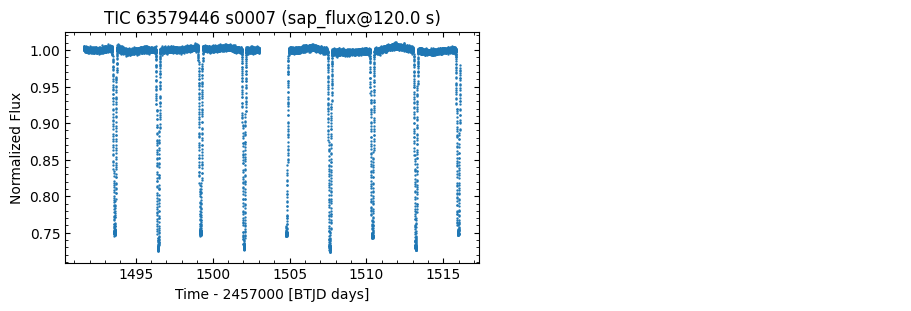

In [13]:
lcs_titles = [f"{target} s{l.sector:04d} ({l.meta['FLUX_ORIGIN']}@{l.meta['FRAMETIM']*l.meta['NUM_FRM']} s)" for l in lcs]
plt.show(_fig := plots.plot_lightcurves(lcs, "flux", lcs_titles, normalize_lcs=True))
plt.close(_fig)

### Process the light curves to create flattened copies with delta_mag columns

First we select regions to exclude from processing. These could be distorted regions of the
light curve, incomplete eclipses or isolated regions with no useful data. Currently there is
no tool for selecting ranges from the light curve plot directly, so instead we parse the text
of an exclude list of (from, to) time tuples taken from all sectors. For example;
```python
[(1420.0, 1424.0), (2158.0, 2160.0)]
```
where the time values are interpreted with the time format and scale of each light curve.

Once we have any time masks we can use these, along with a simple mask which excludes
invalid flux values, to create masked copies of the original light curves. The masked
light curves are then extended with `delta_mag` and `delta_mag_err` columns calculated
from the fluxes. The `delta_mag` values are detrended and rectified in contiguous segments,
which are selected by finding gaps in the timeseries > gap threshold. Each segment is
rectified and detrended by subtracting a fitted polynomial of the selected degree. 

In [14]:
display(VBox(children=[
    (combine_sectors := Checkbox(description=f"Combine {num_sectors} sector(s)", value=target_config.get("combine_sectors", False),
                                 indent=False, layout={"width": "25%"}, style={'description_width': 'max-content'})),
    (time_masks_text := Text(description="Time ranges to exclude:", value=f"{target_config.get('quality_masks', '')}",
                             layout={'width': "50%"}, style={'description_width': 'max-content'})),

    (seg_gap_th := FloatLogSlider(description="segment gap threshold (d):", value=target_config.get("detrend_gap_th", 2.0),
                                  base=10, min=-1, max=3, layout={"width": "25%"}, style={'description_width': 'max-content'})),
    HBox(children=[
        (poly_degr := IntSlider(description="detrend poly degree:", value=target_config.get("detrend_poly_degree", 1),
                                min=1, max=4, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (dtrd_iters := IntSlider(description="detrend iterations:", value=target_config.get("detrend_iterations", 2),
                                 min=1, max=4, layout={"width": "25%"}, style={'description_width': 'max-content'})),
])]))

In [15]:
time_mask_list = []
if len(time_masks_text.value.strip()): # Interpret the list of (from, to) tuples entered above
    time_mask_list = literal_eval(time_masks_text.value)
    if isinstance(time_mask_list, (tuple, int, float)):
        time_mask_list = [time_mask_list]

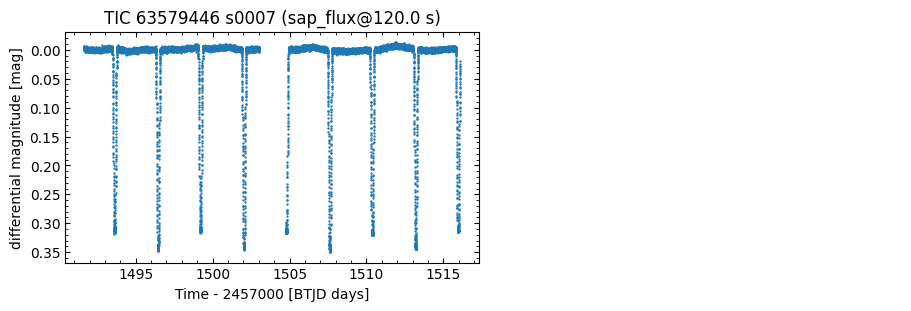

In [16]:
mag_lcs = lk.LightCurveCollection([])
if combine_sectors.value and len(lcs):
    _norm_lcs = [lcs.stitch(lambda lc: lc.normalize())]
    lcs_titles = [f"{target} over {num_sectors} sector(s)"]
else:
    _norm_lcs = (lc.normalize() for lc in lcs)
    
for norm_lc in _norm_lcs:
    # Mask out any invalid fluxes and requested time ranges
    _qual_mask = lightcurves.create_invalid_flux_mask(norm_lc)
    for time_mask_range in (lightcurves.to_lc_time(t, norm_lc) for t in time_mask_list):
        _qual_mask &= (norm_lc.time < np.min(time_mask_range)) | (norm_lc.time > np.max(time_mask_range))
    norm_lc = norm_lc[_qual_mask]

    # Create detrended & rectified delta_mag and delta_mag err columns
    lightcurves.append_magnitude_columns(norm_lc, "delta_mag", "delta_mag_err")
    for s in lightcurves.find_lightcurve_segments(norm_lc, threshold=seg_gap_th.value * u.d):
        norm_lc[s]["delta_mag"] -= lightcurves.fit_polynomial(norm_lc.time[s], norm_lc[s]["delta_mag"],
                                                              poly_degr.value, dtrd_iters.value, 1.0)
    mag_lcs.append(norm_lc)
del _norm_lcs

plt.show(_fig := plots.plot_lightcurves(mag_lcs, "delta_mag", lcs_titles))
plt.close(_fig)

### Review phase folded light curves
First we lookup for the system's ephemeris in the TESS-ebs catalogue based on its TIC. If nothing found then the primary epoch and orbital period must be set manually by inspecting the light curves above.

By default the T0 time is expected to be the time of a primary eclipse. The phase folded light curves will be phase normalized when folded about this point (which becomes phase 0).

In [17]:
_default_t0, _default_period = None, None
if (result := tess_ebs_catalog.query_object(mag_lcs[0].meta["OBJECT"])):
    _default_t0, _default_period = result[0]["BJD0"][0], result[0]["Per"][0]
elif (result := gaia_tbosb_catalog.query_object(search_term)):
    _default_period = result[0]["Per"][0]

display(HBox(children=[
    (t0_text := FloatText(description="Primary epoch (btjd):",  value=target_config.get("t0",  _default_t0),
                          style={'description_width': 'max-content'})),
    (period_text := FloatText(description="Orbital period (d):", value=target_config.get("period", _default_period),
                              style={'description_width': 'max-content'})),
    (double_check := Checkbox(description="Use orbital period x2", value=target_config.get("double_period", False),
                              style={"description_width": "max-content"})),
]))

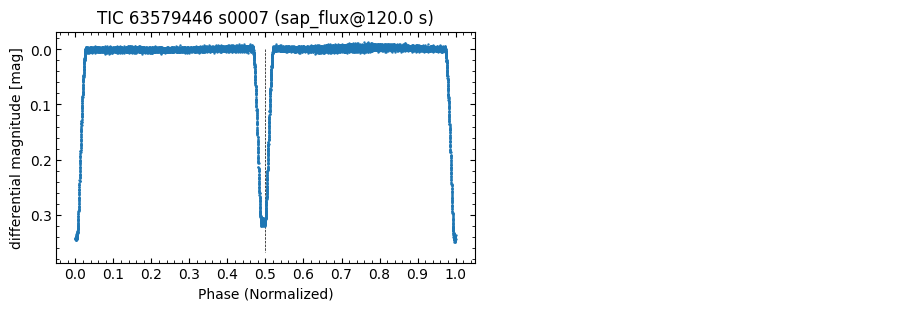

In [18]:
t0 = lightcurves.to_lc_time(t0_text.value, mag_lcs[0])
period = (2 if double_check.value else 1) * (period_text.value * u.d)

def _format_phases(_, ax):
    ax.vlines([0.5], 0, max(ax.get_ylim()), "k", "--", lw=0.5, zorder=-10)
    ax.set_xticks(np.arange(0.0, 1.1, 0.1))

_fig = plots.plot_lightcurves([*(lc.fold(period, t0, wrap_phase=u.Quantity(1), normalize_phase=True) for lc in mag_lcs)],
                             "delta_mag", lcs_titles, ax_func=_format_phases)
plt.show(_fig)
plt.close(_fig)

### Create sampled, phase folded mags data for use with EBOP MAVEN
We now need to make sampled copies of phase folded & phase normalized light curves for
each sector. The EBOP MAVEN model will tell us what wrap it expects for the folded light curves
for estimations through its `mags_feature_wrap_phase` attribute. This will have a value between
0 and 1, or `None`;
- a numeric value indicates the fixed phase above which phased data is expected to be wrapped
to a negative phase
    - a value of 0.75 indicates a phase range of -0.24999 to 0.75, centred on phase 0.25
- a value of `None` indicates the wrap is to ensure the resulting data is centred on the
mid-point between the primary and secondary eclipse
    - in this case the value is calculated from the phase of the secondary eclipse
    which can be set below

In [19]:
if estimator.mags_feature_wrap_phase is None:
    display(HBox(children=[
        (phiS_slider := FloatSlider(description="Phase of secondary eclipse:", value=target_config.get("phiS", 0.5),
                                    min=.01, max=.99, step=.01, layout={"width": "33%"}, style={'description_width': 'max-content'})),
    ]))

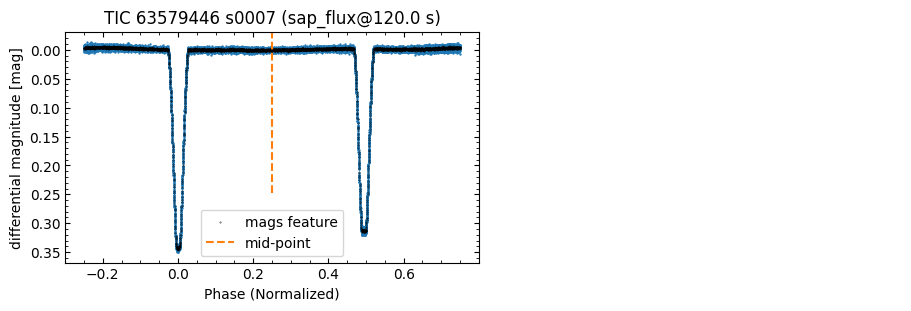

In [20]:
mags_bins = estimator.mags_feature_bins
wrap_phase = u.Quantity(estimator.mags_feature_wrap_phase or (0.5 + phiS_slider.value / 2))
binned_fold = np.zeros(shape=(len(mag_lcs), 2, mags_bins), dtype=np.float32)

_flcs = []
for ix, lc in enumerate(mag_lcs):
    _flcs.append(flc := lc.fold(period, t0, wrap_phase=wrap_phase, normalize_phase=True))
    binned_fold[ix] = lightcurves.get_binned_phase_mags_data(flc, mags_bins, wrap_phase)

def _plot_feature_and_mid(ix, ax):
    ax.scatter(binned_fold[ix, 0], binned_fold[ix, 1], s=0.33, c="k", marker=".", label="mags feature")
    ax.vlines(0.5, 0.3, 1, "tab:orange", "--", lw=1.5, transform=ax.transAxes, label="mid-point")

_fig = plots.plot_lightcurves(_flcs, "delta_mag", lcs_titles, ax_func=_plot_feature_and_mid, legend_loc="best")
plt.show(_fig)
plt.close(_fig)

### Estimate fitting input parameters with EBOP MAVEN
The EBOP MAVEN model will predict values for $r_{\rm A}+r_{\rm B}$, $k$, $J$, $e\cos{\omega}$,
$e\sin{\omega}$ and $b_{\rm P}$ for use as `JKTEBOP` fitting input parameters. To these we will
need to add values for $i$, which can be calculated from the 6 predicted values.

In [21]:
predictions = estimator.predict(binned_fold[:, 1], iterations=1000)
predictions = pipeline.append_calculated_inc_predictions(predictions, "inc")

for lc, preds in zip(mag_lcs, predictions):
    print(f"\nJKTEBOP input parameters for {target} sector {lc.meta['SECTOR']}")
    print(*(f"{p:>12s}: {preds[p] or 0:11.6f}" for p in predictions.dtype.names), sep="\n")


JKTEBOP input parameters for TIC 63579446 sector 7
  rA_plus_rB:    0.173505+/-   0.009787
           k:    0.559384+/-   0.017830
           J:    0.998473+/-   0.034569
       ecosw:   -0.013115+/-   0.005289
       esinw:   -0.024915+/-   0.011985
          bP:    0.297155+/-   0.018127
         inc:   88.151041+/-   0.156619


### Estimate limb darkening parameters
We have starting effective temperature and surface gravity values in the
TESS metadata stored with the light curves, however this refers to system
as a whole. We use J as a simple proxy for the ratio of effective temperatures.

In [22]:
teff_sys = ufloat(mag_lcs[0].meta.get("TEFF", None) or 5650, 300)
logg_sys = ufloat(mag_lcs[0].meta.get("LOGG", None) or 4.0, 0.1)

_J = np.mean(predictions["J"])
_teff = (teff_sys, teff_sys * _J) if _J.n < 1 else (teff_sys / _J, teff_sys)
display(VBox(children=[
    HBox(children=[
        (teffA_text := FloatSlider(description="Effective temp star A (K):", value=_teff[0].n, min=2300, max=12000, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (loggA_text := FloatSlider(description="log(g) star A (dex):", value=logg_sys.n, min=2.5, max=6.0, step=0.5, style={'description_width': 'max-content'})),    
    ]),
    HBox(children=[
        (teffB_text := FloatSlider(description="Effective temp star B (K):", value=_teff[1].n, min=2300, max=12000, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (loggB_text := FloatSlider(description="log(g) star A (dex):", value=logg_sys.n, min=2.5, max=6.0, step=0.5, style={'description_width': 'max-content'})),
    ]),
]))

In [23]:
_ldA_coeffs = limb_darkening.lookup_pow2_coefficients(loggA_text.value, teffA_text.value)
_ldB_coeffs = limb_darkening.lookup_pow2_coefficients(loggB_text.value, teffB_text.value)
ld_params = {
    "LDA": "pow2", "LDA1": _ldA_coeffs[0], "LDA2": _ldA_coeffs[1],
    "LDB": "pow2", "LDB1": _ldB_coeffs[0], "LDB2": _ldB_coeffs[1],
}

### Perform JKTEBOP Task 3 analysis
First we set up the in and dat files for each analysis to be run.

In [24]:
# Superset of all of the potentially fitted parameters
fitted_param_names = ["rA_plus_rB", "k", "J", "ecosw", "esinw", "inc", "L3", "pe", "period", "rA", "rB", "LA", "LB", "light_ratio"]
fitted_params = np.empty(shape=(len(mag_lcs), ), dtype=[(k, np.dtype(UFloat.dtype)) for k in fitted_param_names])

In [25]:
task = 3
fit_dir = jktebop.get_jktebop_dir()
file_fmt = f"quick-fit-{target_file_stem}-{{sector:04d}}.{{ext:s}}"
for ix, (lc, preds) in enumerate(zip(mag_lcs, predictions)):
    _in_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="in")
    _dat_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="dat")
    _par_fname = fit_dir / file_fmt.format(sector=lc.meta['SECTOR'], ext="par")

    _in_params = {
        "task": task,
        "qphot": preds["k"]**1.4,
        "gravA": 0.,                "gravB": 0.,
        "L3": 0.,

        "reflA": 0.,                "reflB": 0.,
        "period": period.value,
        "primary_epoch": t0.value,
        
        "simulations": 100 if task == 8 else "",

        "qphot_fit": 0,
        "ecosw_fit": 1,             "esinw_fit": 1,
        "gravA_fit": 0,             "gravB_fit": 0,
        "L3_fit": 1,
        "LDA1_fit": 1,              "LDB1_fit": 1,
        "LDA2_fit": 0,              "LDB2_fit": 0,
        "reflA_fit": 1,             "reflB_fit": 1,
        "sf_fit": 1,
        "period_fit": 1,            "primary_epoch_fit": 1,

        "data_file_name": _dat_fname.name,
        "file_name_stem": _dat_fname.stem,

        **{ n: preds[n] for n in preds.dtype.names },
        **ld_params,
    }

    # JKTEBOP will fail if it finds files from a previous fitting
    for file in fit_dir.glob(file_fmt.format(sector=lc.meta["SECTOR"], ext="*")):
        file.unlink()
    _segments = lightcurves.find_lightcurve_segments(lc, 0.5, yield_times=True)
    _append_lines = jktebop.build_poly_instructions(_segments, "sf", 1) + ["", "chif", ""]
    jktebop.write_in_file(_in_fname, append_lines=_append_lines, **_in_params)
    jktebop.write_light_curve_to_dat_file(lc, _dat_fname)

    # Blocks on the JKTEBOP task until we can parse the newly written par file contents
    # to read out the revised values for the superset of potentially fitted parameters.
    _pgen = jktebop.run_jktebop_task(_in_fname, _par_fname, stdout_to=sys.stdout)
    for k, v in jktebop.read_fitted_params_from_par_lines(_pgen, fitted_param_names, True).items():
        fitted_params[ix][k] = v

  
JKTEBOP  v44  John Southworth (Keele University, UK, taylorsouthworth~gmail.com)
Task 3  finds the best fit of the model to observations  (formal errorbars only)
>> Read parameters for polynomial  1, to be applied to parameter "sf" over a given time interval
>> Read parameters for polynomial  2, to be applied to parameter "sf" over a given time interval
>> Opened new parameter  file:  quick-fit-tic-63579446-0007.par                   
>> Opened new LC output  file:  quick-fit-tic-63579446-0007.out                   
>> Opened new model fit  file:  quick-fit-tic-63579446-0007.fit                   
>> Read  16310 datapoints (with errors) from file quick-fit-tic-63579446-0007.dat                   
>> Read  2 polynomial datasets from the input file
>> Best fit has been found after 28 iterations.
>> Done iteration 1 to adjust errorbars. Chisqred values:   1.945 
>> Done iteration 2 to adjust errorbars. Chisqred values:   1.000 
>> Best fit has been found after 12 iterations.
  


#### Report of JKTEBOP fitting results

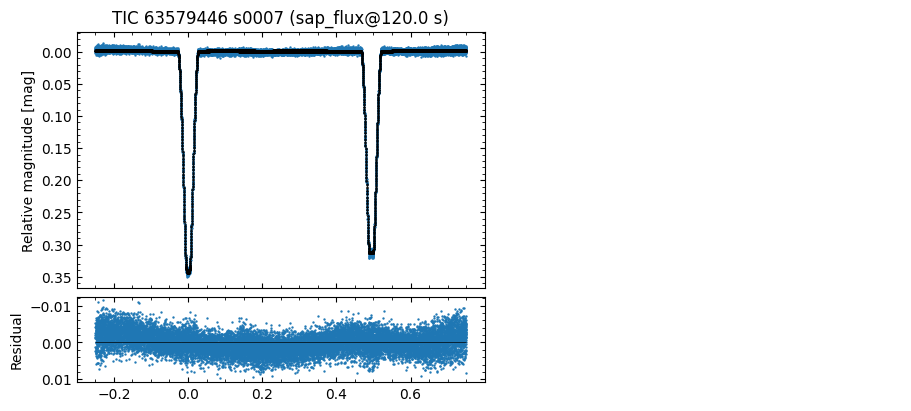

In [26]:
if task == 3:
    rows, cols = int(np.ceil(len(mag_lcs) / 2)), 2
    fig, axes = plt.subplots(rows*2, cols, figsize=(4.5*cols, 4*rows), height_ratios=(3, 1)*rows, constrained_layout=True)

    for ix in range(axes.size//2):
        row, col = int(np.floor(ix / cols) * 2), ix % cols
        ax_lc, ax_res = axes[row, col], axes[row+1, col]
        if ix < len(mag_lcs):
            # Pick columns so they are ordered [phase, lc_mag, model_mag, residual]
            out_file = fit_dir / file_fmt.format(sector=mag_lcs[ix].meta['SECTOR'], ext="out")
            out_data = np.loadtxt(out_file, float, comments="#", usecols=[3, 1, 4, 5], unpack=True)
            out_data[0][out_data[0] > wrap_phase.value] -= 1. # matches wrap used previously
        
            if ix < len(mag_lcs):
                ax_lc.scatter(out_data[0], out_data[1], s=2.0, marker=".", label=None)
                ax_lc.scatter(out_data[0], out_data[2], s=0.5, c="k", marker=".", label=None)
                ax_res.scatter(out_data[0], out_data[3], s=2.0, marker=".", label=None)
                ax_res.hlines([0.0], min(out_data[0]), max(out_data[0]), ls="-", color="k", lw=.5)

                if ix == 0:
                    ax_lc.invert_yaxis()
                    ax_res.invert_yaxis()
                else:
                    ax_lc.sharey(axes[0, 0])
                    ax_res.sharey(axes[1, 0])
        
                # Hides tick labels on inner facing shared axes
                plt.setp(ax_lc.get_xticklabels(), visible=False) 
                if col > 0:
                    plt.setp(ax_lc.get_yticklabels(), visible=False)
                    plt.setp(ax_res.get_yticklabels(), visible=False)
                plots.format_axes(ax_lc, title=lcs_titles[ix], ylabel="" if ix % cols else "Relative magnitude [mag]")
                plots.format_axes(ax_res, ylabel="" if ix % cols else "Residual")
        else:
            ax_lc.axis("off")
            ax_res.axis("off")
    plt.show(fig)
    plt.close(fig)

In [27]:
print(("Mean f" if len(fitted_params) > 1 else "F") + f"itted parameter values and",
      f"formal error bars for {target} over {num_sectors} sector(s)")
print("\n".join(f"{p:>14s}: {fitted_params[p].mean():12.6f}" for p in fitted_params.dtype.names))

Fitted parameter values and formal error bars for TIC 63579446 over 1 sector(s)
    rA_plus_rB:     0.170016+/-    0.000124
             k:     0.603755+/-    0.004309
             J:     1.029817+/-    0.017200
         ecosw:    -0.009859+/-    0.000016
         esinw:    -0.007083+/-    0.001447
           inc:    88.599329+/-    0.058624
            L3:     0.052657+/-    0.008120
            pe:  1496.454490+/-    0.000050
        period:     5.582885+/-    0.000021
            rA:     0.106011+/-           0
            rB:     0.064005+/-           0
            LA:     0.696432+/-           0
            LB:     0.250911+/-           0
   light_ratio:     0.360280+/-           0


In [28]:
teff_ratio = (fitted_params["light_ratio"].mean() / fitted_params["k"].mean()**2)**0.25
radius_ratio = fitted_params["k"].mean()

### Load our support data for MCMC fitting the target's SED

In [29]:
# Extinction model: G23 (Gordon et al., 2023) Milky Way R(V) filter gives us the broadest coverage
ext_model = G23(Rv=3.1)
ext_wl_range = np.reciprocal(ext_model.x_range) * u.um # x_range has implicit units of 1/micron
print(f"Using the {ext_model.__class__.__name__} extinction model which covers the range from",
      f"{min(ext_wl_range):unicode} to {max(ext_wl_range):unicode}.")

Using the G23 extinction model which covers the range from 0.0912 µm to 32.0 µm.


Loads a grid of fluxes, in this case derived from bt-settl-agss models. The StellarGrid
class is used by the SED fitting code to generate model SEDs for fitting.

In [30]:
# Model SED grid based on bt-settl-agss models with known filters pre-applied to non-reddened fluxes
model_grid = BtSettlGrid(verbose=True)

print(f"Loaded grid based on bt-settl models, covering the ranges:")
print(f"wavelength {model_grid.wavelength_range * model_grid.wavelength_unit:unicode},",
      f"Teff {model_grid.teff_range * model_grid.teff_unit:unicode},",
      f"logg {model_grid.logg_range * model_grid.logg_unit:unicode}",
      f"\nand metallicity {model_grid.metal_range * u.dimensionless_unscaled:unicode},",
      f"with fluxes returned in units of {model_grid.flux_unit:unicode}")

BtSettlGrid is initializing the fluxes interpolator with the grid of 86 teff, 6 logg & 4 metal values and 5000 wavelength bins...will use slinear interpolation...done.
Initializing unreddened fluxes for 39 filters.......................................done.
Loaded grid based on bt-settl models, covering the ranges:
wavelength [ 0.05 50.  ] µm, Teff [ 2600. 20000.] K, logg [3.  5.5] dex 
and metallicity [-0.5  0.5], with fluxes returned in units of W m⁻²


### Locate and prepare the target's spectral energy distribution (SED) data
We can query the target's SED with the Vizier SED service which aggregates
flux measurements from various systematic sky surveys. Once we have this
we need to deredden the SED prior to fitting for stellar masses

In [31]:
# Read in the SED for this target and de-duplicate (measurements may appear multiple times).
# Plots are unit agnostic and plot wl [um] and vF(v) [W/m^2] on x and y.
sed = get_sed_for_target(target, search_term, radius=0.1, remove_duplicates=True, verbose=True)

sed = group_and_average_fluxes(sed, verbose=True)

# Filter SED to those covered by our models and also remove any outliers
model_mask = np.ones((len(sed)), dtype=bool)
model_mask &= model_grid.has_filter(sed["sed_filter"])
model_mask &= (sed["sed_wl"] >= min(ext_wl_range)) \
            & (sed["sed_wl"] <= max(ext_wl_range)) \
            & (sed["sed_wl"] >= min(model_grid.wavelength_range)) \
            & (sed["sed_wl"] <= max(model_grid.wavelength_range))
sed = sed[model_mask]

out_mask = create_outliers_mask(sed, teff_sys.n, teff_ratio, min_unmasked=15, verbose=True)
sed = sed[~out_mask]

sed.sort(["sed_wl"])
print(f"{len(sed)} unique SED observation(s) retained after range and outlier filtering",
      "\nwith the units for flux, frequency and wavelength being",
      ", ".join(f"{sed[f].unit:unicode}" for f in ["sed_flux", "sed_freq", "sed_wl"]))

Opened SED table tic-63579446-0.1.vot containing 74 row(s).
Dropped 37 duplicate(s) leaving 37 unique row(s).
Grouped SED by ['sed_filter', 'sed_freq'] yielding 14 group(s) from 37 row(s).
Calculating the group means of the [('sed_flux', 'sed_eflux')] columns
No outliers masked as already 15 or fewer SED rows
13 unique SED observation(s) retained after range and outlier filtering 
with the units for flux, frequency and wavelength being W Hz⁻¹ m⁻², Hz, µm


In [32]:
for val, flags in extinction.get_ebv(target_coords, rv=ext_model.Rv):
    if val and not np.isnan(val) and flags.get("converged", False):
        print(f"Found extinction with {flags['source']}: E(B-V) = {val:.6f}")
        sed["sed_der_flux"] = sed["sed_flux"] / ext_model.extinguish(sed["sed_wl"].to(u.um), Ebv=val)
        break

if "sed_der_flux" in sed.colnames:
    der_lab = "dereddened"
else:
    sed["sed_der_flux"] = sed["sed_flux"]
    der_lab = "not dereddened"

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 25.491 s
  pix_info:   0.343 s
   samples:  14.308 s
      best:   2.779 s
       nan:   0.020 s
      sort:   7.966 s
       idx:   0.076 s
Found extinction with get_bayestar_ebv: E(B-V) = 0.029880


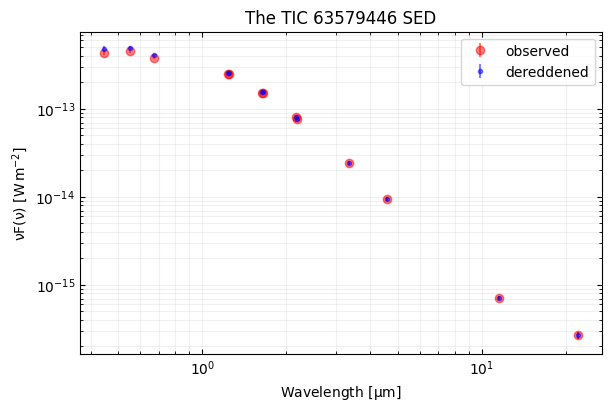

In [33]:
plt.show(plots.plot_sed(sed["sed_wl"].quantity,
                        fluxes=[sed["sed_flux"].quantity, sed["sed_der_flux"].quantity],
                        flux_errs=[sed["sed_eflux"].quantity]*2,
                        fmts=["or", ".b"],
                        labels=["observed", der_lab],
                        title=f"The {target} SED"))
plt.close()

### Set up the functions which will support SED fitting

We set the starting position for the fit, `theta0`, which is our best estimate of the
fitted values for the system based on existing published data and any light-curve fitting carried
out previously.

The `fit_mask` indicates which of the values in `theta0` is fitted, with the remainder being fixed.

**Note:** currently we're not fitting for $\log{g}$, instead using fixed values for each star.

In [34]:
NUM_STARS = 2

subs = "ABCDEFGHIJKLM"
theta_plot_labels = np.array([f"$T_{{\\rm eff,{subs[st]}}} / {{\\rm K}}$" for st in range(NUM_STARS)] \
                            +[f"$\\log{{g}}_{{\\rm {subs[st]}}}$" for st in range(NUM_STARS)] \
                            +[f"$R_{{\\rm {subs[st]}}} / {{\\rm R_{{\\odot}}}}$" for st in range(NUM_STARS)] \
                            +["${\\rm D} / {\\rm pc}$", "${\\rm A_{V}}$"])

theta_labels = np.array([(f"Teff{subs[st]}", u.K) for st in range(NUM_STARS)] \
                        +[(f"logg{subs[st]}", u.dex) for st in range(NUM_STARS)] \
                        +[(f"R{subs[st]}", u.Rsun) for st in range(NUM_STARS)] \
                        +[("D", u.pc), ("av", u.dimensionless_unscaled)])

In [35]:
theta0 = create_theta(teffs=teff_sys.n,
                      loggs=4.0,
                      radii=1.0,
                      dist=target_coords.distance.to(u.pc).value,
                      av=0,
                      nstars=NUM_STARS,
                      verbose=True)

fit_mask = np.array([True] * NUM_STARS      # teff
                  + [False] * NUM_STARS     # logg
                  + [True] * NUM_STARS      # radius
                  + [True]                  # dist
                  + [False])                # av (we've handled av by derredening the SED)

theta:	 6.213e+03, 6.213e+03, 4.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 4.982e+02, 0.000e+00


Here we set up priors' limit and ratio criteria for the fitting. This is in the form of a
callback function which the fitting code invokes at the start of each iteration.

In [36]:
# For now, hard coded to 2 stars. Same order as theta: teff, radii (, logg, dist are not fitted)
teff_limits = model_grid.teff_range
radius_limits = (0.1, 100)

# Ratios wrt the primary components - we ignore the 0th item
teff_ratios = [ufloat(teff_ratio.n, max(teff_ratio.s, teff_ratio.n * 0.03))] * NUM_STARS
radius_ratios = [ufloat(radius_ratio.n, max(radius_ratio.s, radius_ratio.n * 0.03))] * NUM_STARS

dist_prior = ufloat(target_coords.distance.value, target_coords.distance.value * 0.03)

def ln_prior_func(theta: np.ndarray[float]) -> float:
    """
    The fitting prior callback function to evaluate the current set of candidate
    parameters (theta), returning a single ln(value) indicating their "goodness".
    """
    teffs = theta[0:NUM_STARS]
    radii = theta[NUM_STARS*2:NUM_STARS*3]
    dist = theta[-2]

    # Limit criteria checks - hard pass/fail on these
    if not all(teff_limits[0] <= t <= teff_limits[1] for t in teffs) or \
        not all(radius_limits[0] <= r <= radius_limits[1] for r in radii):
        return np.inf

    # Gaussian prior criteria: g(x) = 1/(σ*sqrt(2*pi)) * exp(-1/2 * (x-µ)^2/σ^2)
    # Omitting scaling expressions for now and note the implicit ln() cancelling the exp
    ret_val = 0
    for star_ix in range(1, NUM_STARS):
        ret_val += ((teffs[star_ix] / teffs[0] - teff_ratios[star_ix].n) / teff_ratio.s)**2
        ret_val += ((radii[star_ix] / radii[0] - radius_ratios[star_ix].n) / teff_ratio.s)**2
    ret_val += ((dist - dist_prior.n) / dist_prior.s)**2
    return 0.5 * ret_val

Get the observed SED data into a format for fitting. Flux units need to match
those produced by the model grid.

In [37]:
# Prepare the data to be fitted
x = model_grid.get_filter_indices(sed["sed_filter"])
y = (sed["sed_der_flux"].quantity * sed["sed_freq"].quantity)\
                                    .to(model_grid.flux_unit, equivalencies=u.spectral()).value
y_err = (sed["sed_eflux"].quantity * sed["sed_freq"].quantity)\
                                    .to(model_grid.flux_unit, equivalencies=u.spectral()).value

#### Run a "quick" minimize fit

In [38]:
theta_min_fit, _ = minimize_fit(x, y, y_err=y_err, theta0=theta0, fit_mask=fit_mask,
                                ln_prior_func=ln_prior_func, stellar_grid=model_grid, verbose=True)

minimize_fit(theta0=[6.213e+03*, 6.213e+03*, 4.000e+00, 4.000e+00, 1.000e+00*, 1.000e+00*, 4.982e+02*, 0.000e+00])
(Nelder-Mead) succeeded after 360 iterations & 589 function evaluation(s) [fun = 4.910610]
(SLSQP) succeeded after 39 iterations & 243 function evaluation(s) [fun = 4.910610]
(None) failed [Desired error not necessarily achieved due to precision loss.] after 59 iterations & 504 function evaluation(s) [fun = 4.910610]
The best fit with Nelder-Mead method yielded theta=[6.036e+03*, 6.018e+03*, 4.000e+00, 4.000e+00, 1.768e+00*, 1.067e+00*, 4.982e+02*, 0.000e+00]


Best fit parameters for TIC 63579446 from minimization fit (* indicates fitted parameter): 
       TeffA* = 6036.104 K 
       TeffB* = 6018.475 K 
       loggA  = 4.000 dex 
       loggB  = 4.000 dex 
          RA* = 1.768 R☉ 
          RB* = 1.067 R☉ 
           D* = 498.241 pc 
          av  = 0.000 


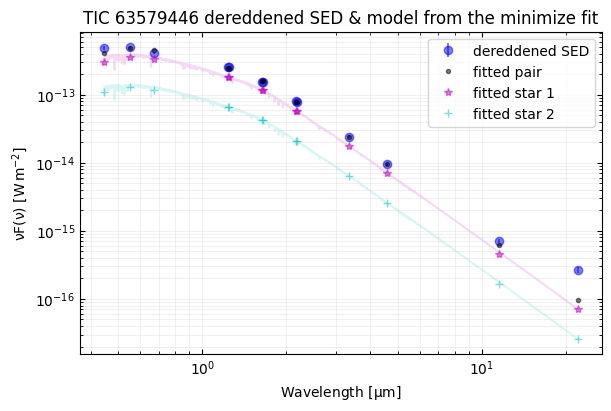

In [39]:
print(f"Best fit parameters for {target} from minimization fit (* indicates fitted parameter):",
      *(f"\n{l:>12s}{'*' if f else ' ':s} = {t:.3f} {u:unicode}" 
                        for t, f, (l, u) in zip(theta_min_fit, fit_mask, theta_labels)))
plt.show(plots.plot_fitted_model(sed, theta_min_fit, model_grid,
                                 title=f"{target} dereddened SED & model from the minimize fit"))
plt.close()

#### Perform MCMC SED fitting for more reliable fit from a probability distribution

In [40]:
thin_by = 10 # sample every nth step from the chain
theta_mcmc_fit, sampler = mcmc_fit(x, y, y_err, theta0=theta_min_fit, fit_mask=fit_mask,
                                   ln_prior_func=ln_prior_func, stellar_grid=model_grid, 
                                   nwalkers=100, nsteps=100000, thin_by=thin_by, seed=42,
                                   early_stopping=True, processes=8, progress=True, verbose=True)

mcmc_fit(theta0=[6.036e+03*, 6.018e+03*, 4.000e+00, 4.000e+00, 1.768e+00*, 1.067e+00*, 4.982e+02*, 0.000e+00])
Running MCMC fit with 100 walkers for 100000 steps, thinned by 10, on 8 process(es). Early stopping is enabled after 2500 steps.


 12%|█▏        | 12000/100000 [05:40<41:33, 35.29it/s]


Halting MCMC after 12000 steps as the walkers are past 100 times the autocorrelation time & the fit has converged.
Autocorrelation steps (tau): 51.699, 51.691, 56.052, 55.705, 55.688
Estimated burn-in steps:     112
Mean Acceptance fraction:    0.551
The MCMC fit yielded theta:  [(6.040+/-0.119)e+03*, (6.022+/-0.119)e+03*, (4.000+/-0)e+00, (4.000+/-0)e+00, (1.770+/-0.065)e+00*, (1.069+/-0.039)e+00*, (4.991+/-0.148)e+02*, (0.000+/-0)e+00]


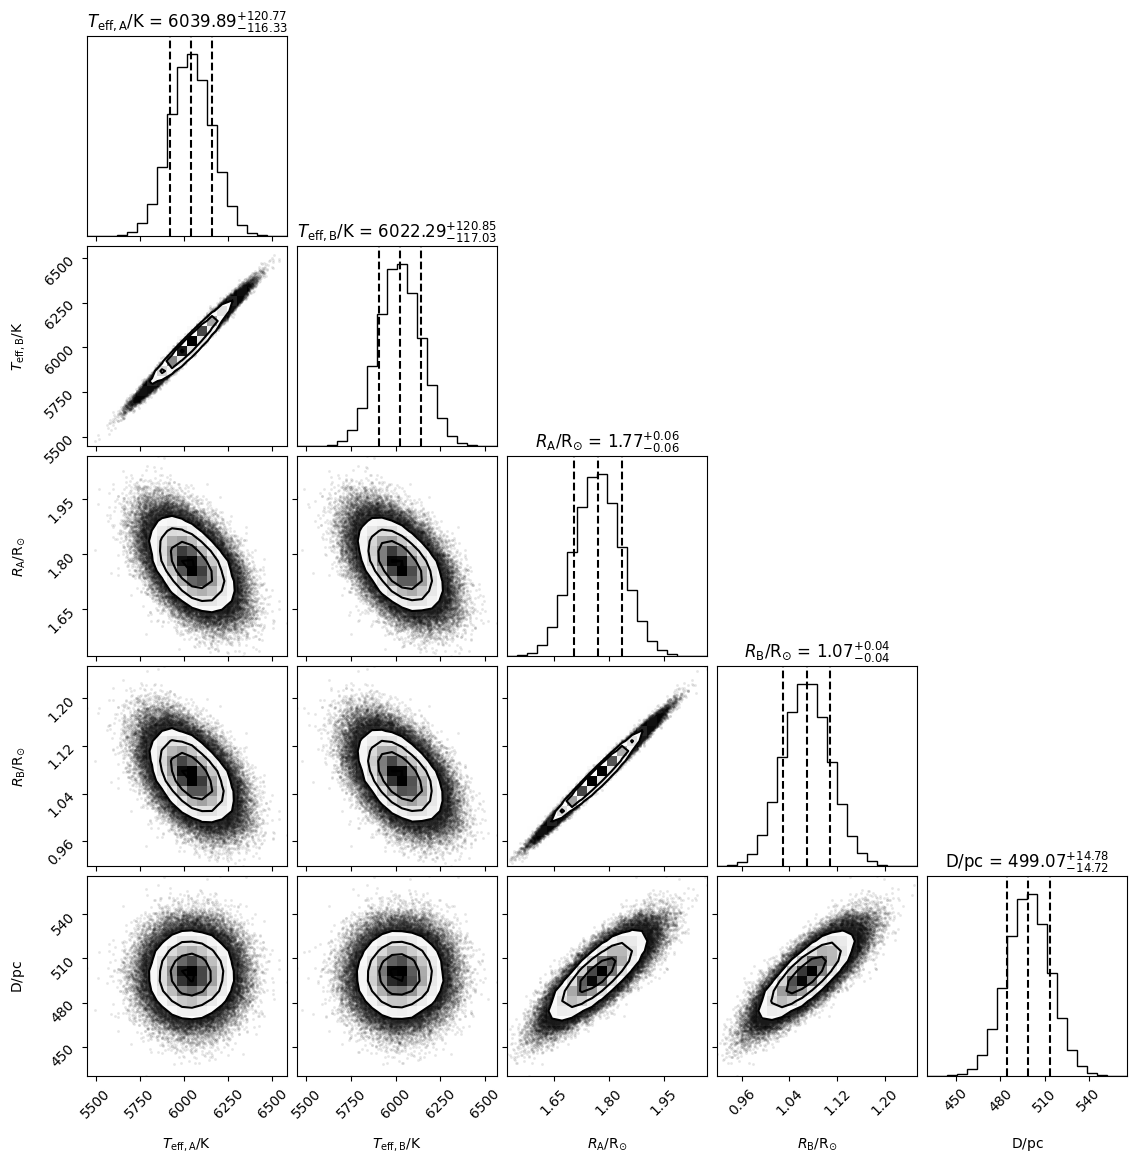

In [41]:
tau = sampler.get_autocorr_time(c=5, tol=50, quiet=True) * thin_by
burn_in_steps = int(max(np.nan_to_num(tau, copy=True, nan=1000)) * 2)
samples = sampler.get_chain(discard=burn_in_steps, flat=True)
plt.show(corner.corner(samples, show_titles=True, plot_datapoints=True,
                       quantiles=[0.16, 0.5, 0.84], labels=theta_plot_labels[fit_mask]))
plt.close()


Final parameters for TIC 63579446 with nominals & 1-sigma error bars from MCMC fit
       TeffA = 6039.882+/-118.545 K (known value nan+/-0 K)
       TeffB = 6022.292+/-118.929 K (known value nan+/-0 K)
          RA = 1.770+/-0.065 R☉ (known value nan+/-0 R☉)
          RB = 1.069+/-0.039 R☉ (known value nan+/-0 R☉)
           D = 499.067+/-14.752 pc (known value nan+/-0 pc)


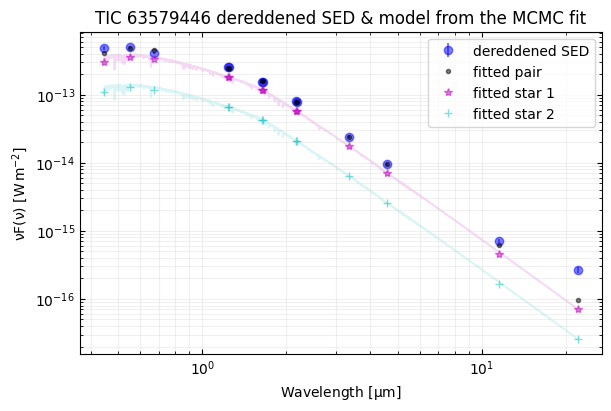

In [42]:
print(f"\nFinal parameters for {target} with nominals & 1-sigma error bars from MCMC fit")
for (param, unit), fit in zip(theta_labels[fit_mask], theta_mcmc_fit[fit_mask]):
    known = ufloat(target_config.get(param, np.NaN), target_config.get(param+"_err", None) or 0)
    print(f"{param:>12s} = {fit:.3f} {unit:unicode} (known value {known:.3f} {unit:unicode})")

plt.show(plots.plot_fitted_model(sed, theta_mcmc_fit, model_grid,
                                 title=f"{target} dereddened SED & model from the MCMC fit"))
plt.show(fig)
plt.close(fig)

### Find orbital parameters based on results of fitting

In [43]:
teffA, teffB = theta_mcmc_fit[0], theta_mcmc_fit[1]
RA, RB = theta_mcmc_fit[4], theta_mcmc_fit[5]

# semi-major axis
a = np.mean([RA / fitted_params["rA"].mean(), RB / fitted_params["rB"].mean()])
print(f"semi-major axis (a):       {a:.3f} {u.Rsun:unicode} (from fitted radii)")

# total mass of the system
sys_mass = (4 * np.pi**2 * (a * R_sun)**3) / (G * (fitted_params["period"].mean() * 86400)**2) / M_sun
print(f"total system mass (M_sys): {sys_mass:.3f} {u.Msun:unicode} (from semi-major axis & period)")

semi-major axis (a):       16.700+/-0.432 R☉ (from fitted radii)
total system mass (M_sys): 2.005+/-0.156 M☉ (from semi-major axis & period)


In [44]:
import libs.fit_masses as fit_masses

def print_mass_theta(theta, label: str="theta"):
    print(f"{label} = [" + ", ".join(f"{t:.3e}" for t in theta) + "]\n") 

# Observations from SED fitting
obs_radii = np.array([RA, RB])
obs_teffs = np.array([teffA, teffB])

# Estimate fit starting position as a masses based on the observed radii and a reasonable M-S age
theta_masses = np.array([sys_mass * r for r in obs_radii])
theta_masses *= (sys_mass / np.sum(theta_masses))
theta0 = np.concatenate([nominal_values(theta_masses), [8.5]]) # initial masses and log age
print_mass_theta(theta0, "theta0")

theta_min_fit, _ = fit_masses.minimize_fit(theta0, sys_mass, obs_radii, obs_teffs, verbose=True)
print_mass_theta(theta_min_fit, "theta_min_fit")

Reading in: /home/steveo/projects/main/platodebcat/libs/data/mist/MIST_v1.2_vvcrit0.4_basic_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_basic.iso
theta0 = [1.250e+00, 7.548e-01, 8.500e+00]

(Nelder-Mead) succeeded after 127 iterations & 245 function evaluation(s) [fun = 4.298220]
(SLSQP) succeeded after 12 iterations & 74 function evaluation(s) [fun = 47.958434]
(None) failed [Desired error not necessarily achieved due to precision loss.] after 7 iterations & 334 function evaluation(s) [fun = 49.478569]
Taking the best fit from the Nelder-Mead method
theta_min_fit = [1.002e+00, 9.306e-01, 9.995e+00]



In [45]:
thin_by = 10
theta_mcmc_fit, sampler = fit_masses.mcmc_fit(theta_min_fit, sys_mass, obs_radii, obs_teffs,
                                              nwalkers=100, nsteps=100000, thin_by=thin_by, seed=42,
                                              early_stopping=True, processes=8, progress=True, verbose=True)
print_mass_theta(theta_mcmc_fit, "theta_mcmc_fit")

100%|██████████| 100000/100000 [20:08<00:00, 82.78it/s]


Autocorrelation steps (tau): 105.484, nan, nan
Estimated burn-in steps:     2,000
Mean Acceptance fraction:    0.457
theta_mcmc_fit = [(1.173+/-0.073)e+00, (1.008+/-0.035)e+00, (9.712+/-0.124)e+00]



In [46]:
theta_plot_labels = np.array([f"$M_{{\\rm {subs[st]}}} / {{\\rm M_{{\\odot}}}}$" for st in range(NUM_STARS)] \
                            +["$\\log{{({{\\rm age}})}} / {{\\rm yr}}$"])

theta_labels = np.array([(f"M{subs[st]}", u.Msun) for st in range(NUM_STARS)] \
                        +[("log(age)", u.dex(u.yr))])

print(f"\nFinal parameters for {target} with nominals & 1-sigma error bars from MCMC fit")
for (param, unit), fit in zip(theta_labels, theta_mcmc_fit):
    known = ufloat(target_config.get(param, np.NaN), target_config.get(param+"_err", None) or 0)
    print(f"{param:>12s} = {fit:.3f} {unit:unicode} (known value {known:.3f} {unit:unicode})")


Final parameters for TIC 63579446 with nominals & 1-sigma error bars from MCMC fit
          MA = 1.173+/-0.073 M☉ (known value nan+/-0 M☉)
          MB = 1.008+/-0.035 M☉ (known value nan+/-0 M☉)
    log(age) = 9.712+/-0.124 dex(yr) (known value nan+/-0 dex(yr))


/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


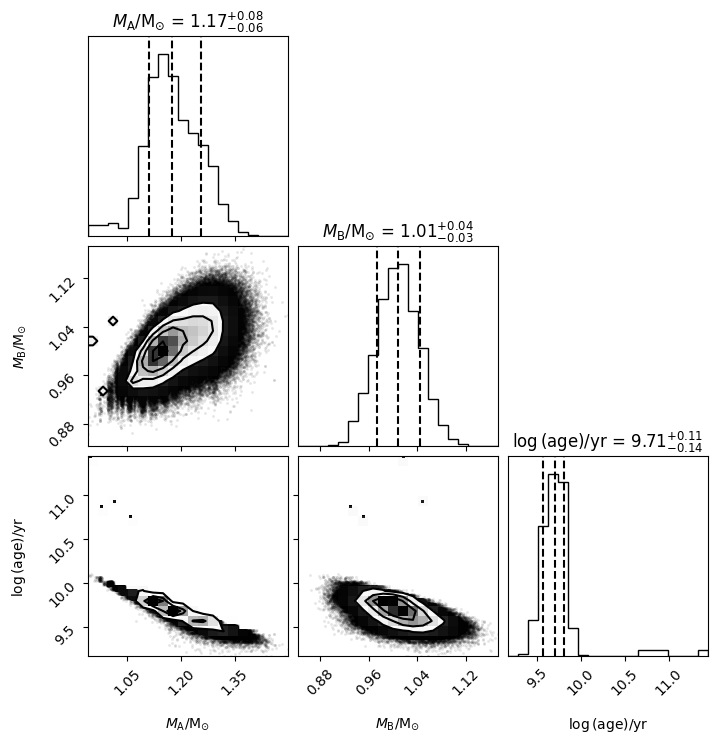

In [47]:
tau = sampler.get_autocorr_time(c=5, tol=50, quiet=True) * thin_by
burn_in_steps = int(max(np.nan_to_num(tau, copy=True, nan=1000)) * 2)
samples = sampler.get_chain(discard=burn_in_steps, flat=True)

plt.show(corner.corner(samples, show_titles=True, plot_datapoints=True,
                       quantiles=[0.16, 0.5, 0.84], labels=theta_plot_labels))
plt.close()